In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib ipympl

In [7]:
# Read the CSV files
# ft_sensor_data = pd.read_csv('8_ft_sensor_data_20251030_235747.csv')
# psoc_data = pd.read_csv('8_20251030_235512_test8_actually_tocuhing_properly_plz_red_data.csv')

ft_sensor_data = pd.read_csv('ft_sensor_data_20251023_021626.csv')
psoc_data = pd.read_csv('20251029_195156__C__Users_Will_miniconda3_shell_condabin_conda-hook.ps1_____conda_activate_base__data.csv')



# Display basic information about the datasets
print("FT Sensor Data Info:")
print(ft_sensor_data.info())
print("\nFirst few rows of FT Sensor Data:")
print(ft_sensor_data.head())

# print("\nPSOC Data Info:")
# print(psoc_data.info())
# print("\nFirst few rows of PSOC Data:")
# print(psoc_data.head())
psoc_data

FT Sensor Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34500 entries, 0 to 34499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  34500 non-null  float64
 1   fx         34500 non-null  float64
 2   fy         34500 non-null  float64
 3   fz         34500 non-null  float64
 4   tx         34500 non-null  float64
 5   ty         34500 non-null  float64
 6   tz         34500 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB
None

First few rows of FT Sensor Data:
   timestamp        fx        fy        fz        tx        ty        tz
0  23.519599  0.004518 -0.009007  0.017876  0.000470 -0.000188 -0.000002
1  23.520598 -0.016964 -0.026268 -0.070142 -0.000712  0.000346 -0.000037
2  23.521598 -0.000815  0.015046  0.016088 -0.000005 -0.000156  0.000071
3  23.522599 -0.002626 -0.005877  0.033185  0.000164  0.000242  0.000158
4  23.523598 -0.003428 -0.006228  0.050814  0.000327  0.000351 -0.

,Value,Mode,Port,Timestamp Sent,Timestamp Received
0,126.0,0.0,0.0,55474.0,1.761786e+12
1,29.0,0.0,1.0,55310.0,1.761786e+12
2,29.0,0.0,2.0,55465.0,1.761786e+12
3,29.0,0.0,3.0,55903.0,1.761786e+12
4,29.0,0.0,4.0,55090.0,1.761786e+12
...,...,...,...,...,...
4218,29.0,1.0,5.0,56149.0,1.761786e+12
4219,29.0,1.0,6.0,56018.0,1.761786e+12
4220,29.0,1.0,7.0,56165.0,1.761786e+12
4221,126.0,0.0,0.0,55478.0,1.761786e+12


In [ ]:
###################### pre-process PSOC data: ######################

#### fix the timestamps #############

# Identify the first column (assumed to be timestamps)
col0 = psoc_data.columns[0]

# Ensure numeric dtype
psoc_data[col0] = pd.to_numeric(psoc_data[col0], errors='coerce')

# Add 10000 to each negative element in the first column
psoc_data.loc[psoc_data[col0] < 0, col0] += 10000

# Accumulate the column in an "accumulation-esque" fashion (running sum)
psoc_data[col0] = psoc_data[col0].cumsum() / 10000 # 10 khz clock

##### Creating new Super Array #########

# Create an n x 17 array: column 0 = timestamp, columns 1-16 = channels (8*mode + pin)
n = len(psoc_data)
psoc_matrix = np.full((n, 17), np.nan, dtype=float)

# Fill timestamp column (already processed above)
psoc_matrix[:, 0] = psoc_data[col0].values 

# Assume the incoming columns are in positions 1 (mode), 2 (pin), 3 (value)
mode_col = psoc_data.columns[1]
pin_col = psoc_data.columns[2]
val_col  = psoc_data.columns[3]

# Convert to numeric arrays
modes = pd.to_numeric(psoc_data[mode_col], errors='coerce').to_numpy(dtype=float)
pins  = pd.to_numeric(psoc_data[pin_col],  errors='coerce').to_numpy(dtype=float)
vals  = pd.to_numeric(psoc_data[val_col],  errors='coerce').to_numpy(dtype=float)

# Compute channel indices and guard against invalid entries
indices = 8 * modes + pins  # expected range: 0..15
valid = np.isfinite(indices) & (indices >= 0) & (indices < 16) & np.isfinite(vals)

rows = np.nonzero(valid)[0]
cols = indices[valid].astype(int) + 1  # +1 because column 0 is timestamp

# Populate matrix
psoc_matrix[rows, cols] = vals[valid]

###### interpolation ##########

# Convert to DataFrame for easier manipulation
col_names = ['timestamp'] + [f'ch{i}' for i in range(1, 17)]
df_psoc = pd.DataFrame(psoc_matrix, columns=col_names)

# Use pandas interpolate() column-wise (treat exact zeros as missing)

# Treat exact 0.0 as missing for sensor columns (do not touch timestamp)
sensor_cols = col_names[1:]
df_psoc[sensor_cols] = df_psoc[sensor_cols].replace(0.0, np.nan)

# Interpolate column-wise. 'linear' uses row order; limit_area='inside' avoids extrapolation.
df_psoc.interpolate(method='linear', axis=0, limit_area='inside', inplace=True)

# Replace any remaining NaNs with 0.0 to keep the matrix numeric
df_psoc.fillna(0.0, inplace=True)

##### Biasing ##########
# Subtract the first non-zero (finite) element from each channel column (ch1..ch16)
sensor_cols = df_psoc.columns[1:]  # ch1..ch16
for col in sensor_cols:
    col_ser = df_psoc[col]
    nonzero_mask = col_ser.notna() & (col_ser != 0)
    if nonzero_mask.any():
        first_val = col_ser.loc[nonzero_mask].iloc[0]
        # subtract from all finite values in the column
        finite_mask = col_ser.notna()
        df_psoc.loc[finite_mask, col] = df_psoc.loc[finite_mask, col] - first_val

##### gets rid of first and last 16 samples #########
df_psoc = df_psoc.iloc[16:-16].reset_index(drop=True)
psoc_data = df_psoc.copy()
print(df_psoc.head(10))


   timestamp    ch1      ch2     ch3      ch4     ch5      ch6      ch7  \
0     0.0782 -3.000  10.3125 -2.6250  -8.1250 -3.7500  11.0000   8.7500   
1     0.0811 -2.875  11.0000 -2.8125  -8.7500 -4.0625  12.0000   9.6250   
2     0.0840 -2.750  11.1875 -3.0000  -9.3750 -4.3750  13.0000  10.5000   
3     0.0869 -2.625  11.3750 -2.3125 -10.0000 -4.6875  14.0000  11.3750   
4     0.0898 -2.500  11.5625 -1.6250  -9.6875 -5.0000  15.0000  12.2500   
5     0.0927 -2.375  11.7500 -0.9375  -9.3750 -5.1250  16.0000  13.1250   
6     0.0956 -2.250  11.9375 -0.2500  -9.0625 -5.2500  14.9375  14.0000   
7     0.0984 -2.125  12.1250  0.4375  -8.7500 -5.3750  13.8750  13.3125   
8     0.1110 -2.000  12.3125  1.1250  -8.4375 -5.5000  12.8125  12.6250   
9     0.1139 -1.875  12.5000  1.8125  -8.1250 -5.6250  11.7500  11.9375   

       ch8      ch9    ch10    ch11    ch12   ch13   ch14    ch15   ch16  
0  14.6250   7.5000  1.3125  2.6250 -0.9375 -1.500 -0.375  0.1250  0.125  
1  16.2500   8.4375  1.5

In [9]:

# Normalize timestamps by making them relative to start time
ft_start_time = ft_sensor_data['timestamp'].iloc[0]

# use the processed PSOC dataframe (df_psoc) which contains 'timestamp'

psoc_start_time = psoc_data['timestamp'].iloc[0]

# Modify the timestamp columns in place
ft_sensor_data['timestamp'] = ft_sensor_data['timestamp'] - ft_start_time
psoc_data['timestamp'] = (psoc_data['timestamp'] - psoc_start_time) 
#34.3



In [14]:
# Finds the time where We start applying force:
# make copies

ft_copy = ft_sensor_data.copy()
psoc_copy = psoc_data.copy()

# compute row-wise average excluding timestamp
ft_mean = ft_copy.drop(columns=['timestamp']).sum(axis=1).to_numpy()
psoc_mean = psoc_copy.drop(columns=['timestamp']).sum(axis=1).to_numpy()

ft_times = ft_copy['timestamp'].to_numpy()
psoc_times = psoc_copy['timestamp'].to_numpy()

def find_step_time(times, values, threshold=0.1, window_size=3):
    """
        Find the first time where values change by more than threshold
        within a window of 'persistence' samples.
        
        Args:
            times: array of timestamps
            values: array of values
            threshold: minimum change to detect
            window_size: number of samples to look ahead
        
        Returns:
            timestamp where step occurs, or None if no step found
    """
    for i in range(len(values) - window_size):
        if abs(values[i + window_size] - values[i]) > threshold:
            return times[i]
    return None

ft_change_time = find_step_time(ft_times, ft_mean, threshold=1, window_size=100)
psoc_change_time = find_step_time(psoc_times, psoc_mean, threshold=1, window_size=100)

# use PSOC offset as primary if available, otherwise fall back to FT
offset_time = ft_change_time - psoc_change_time 
print(f"FT change time: {ft_change_time}")
print(f"PSOC change time: {psoc_change_time}")
print(f"offset_time (set to PSOC if available) = {offset_time}")

# Apply the offset to PSOC timestamps so it aligns with FT sensor data
psoc_data['timestamp'] = (psoc_data['timestamp'] + offset_time)


FT change time: 1.9631115000000001
PSOC change time: 3.149045000000001
offset_time (set to PSOC if available) = -1.1859335000000009


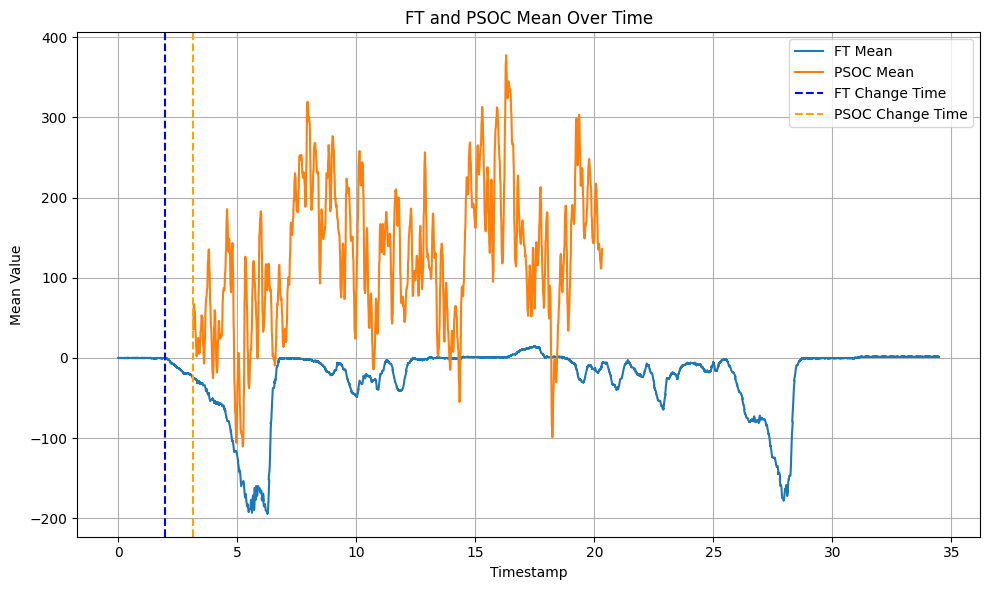

In [15]:
import matplotlib.pyplot as plt

# Plot FT mean
plt.figure(figsize=(10, 6))
plt.plot(ft_times, ft_mean, label='FT Mean', linewidth=1.5)
plt.plot(psoc_times, psoc_mean, label='PSOC Mean', linewidth=1.5)

# Add vertical lines showing where changes occur
if ft_change_time is not None:
    plt.axvline(ft_change_time, color='blue', linestyle='--', label='FT Change Time')
if psoc_change_time is not None:
    plt.axvline(psoc_change_time, color='orange', linestyle='--', label='PSOC Change Time')

plt.title('FT and PSOC Mean Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [16]:
# Negate all force and torque measurements from FT sensor
force_torque_columns = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']
ft_sensor_data[force_torque_columns] = ft_sensor_data[force_torque_columns]

In [17]:
# Calculate durations
ft_duration = ft_sensor_data['timestamp'].iloc[-1] - ft_sensor_data['timestamp'].iloc[0]

# Calculate time step in PSOC data
psoc_duration = psoc_data['timestamp'].iloc[-1] - psoc_data['timestamp'].iloc[0]

print(f"FT Sensor Data duration: {ft_duration:.2f} seconds")
print(f"PSOC Data duration: {psoc_duration:.6f} seconds")
print(f"\nNumber of samples:")
print(f"FT Sensor Data: {len(ft_sensor_data)} samples")
print(f"PSOC Data: {len(psoc_data)} samples")


FT Sensor Data duration: 34.47 seconds
PSOC Data duration: 17.173600 seconds

Number of samples:
FT Sensor Data: 34500 samples
PSOC Data: 4191 samples


C:\Users\Will\AppData\Local\Temp\ipykernel_37088\2172799827.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent label overlap


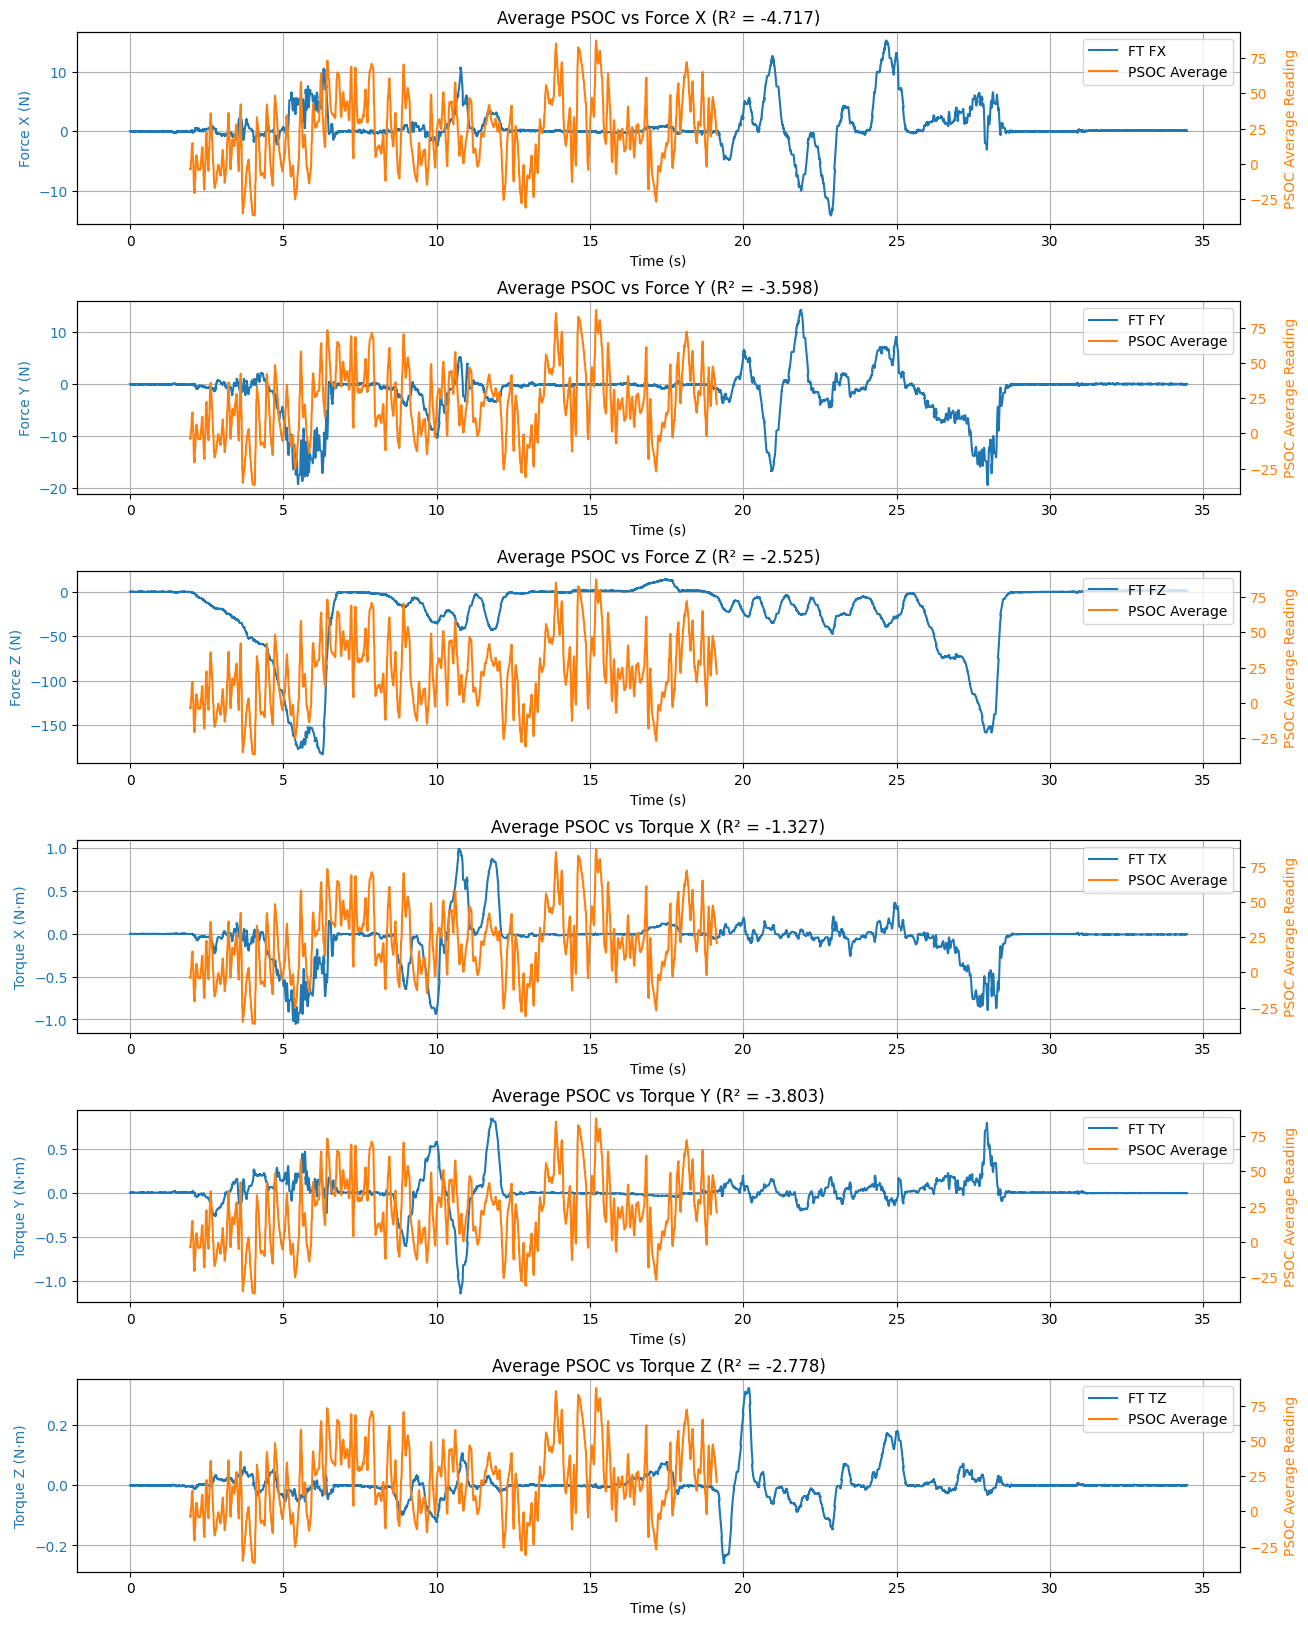

In [18]:
# Calculate average of c1normal through c4normal
avg_normal = psoc_data['ch1'] + psoc_data['ch2'] +psoc_data['ch3'] + psoc_data['ch4']

# Function to calculate R-squared
def calculate_r2(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Create figure with subplots for each force/torque measurement
fig = plt.figure(figsize=(15, 20))
gs = fig.add_gridspec(6, 1, hspace=0.4)

# Plot titles and data to plot
plot_data = [
    ('Average PSOC vs Force X', 'fx', 'Force X (N)'),
    ('Average PSOC vs Force Y', 'fy', 'Force Y (N)'),
    ('Average PSOC vs Force Z', 'fz', 'Force Z (N)'),
    ('Average PSOC vs Torque X', 'tx', 'Torque X (N⋅m)'),
    ('Average PSOC vs Torque Y', 'ty', 'Torque Y (N⋅m)'),
    ('Average PSOC vs Torque Z', 'tz', 'Torque Z (N⋅m)')
]

# Create each subplot
for idx, (title, ft_col, ylabel) in enumerate(plot_data):
    ax1 = fig.add_subplot(gs[idx])
    
    # Plot FT sensor data
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel(ylabel, color='tab:blue')
    line1 = ax1.plot(ft_sensor_data['timestamp'], ft_sensor_data[ft_col], 
                     color='tab:blue', label=f'FT {ft_col.upper()}')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create second y-axis and plot PSOC data
    ax2 = ax1.twinx()
    ax2.set_ylabel('PSOC Average Reading', color='tab:orange')
    
    line2 = ax2.plot(psoc_data['timestamp'], avg_normal, 
                     color='tab:orange', label='PSOC Average')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # Calculate R-squared
    # First interpolate FT sensor data to match PSOC timestamps
    ft_interp = np.interp(psoc_data['timestamp'], 
                         ft_sensor_data['timestamp'], 
                         ft_sensor_data[ft_col])
    
    # Scale both signals to 0-1 range for fair R-squared comparison
    ft_scaled = (ft_interp - ft_interp.min()) / (ft_interp.max() - ft_interp.min())
    psoc_scaled = (avg_normal - avg_normal.min()) / \
                 (avg_normal.max() - avg_normal.min())
    
    r2 = calculate_r2(ft_scaled, psoc_scaled)
    
    # Add title with R-squared and combine legends
    ax1.set_title(f"{title} (R² = {r2:.3f})")
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.grid(True)
    ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()  # Adjust layout to prevent label overlap

In [438]:
# Map PSOC data to FT sensor data (6 outputs) by finding closest timestamps
# PSOC inputs: all sensor columns except timestamp
# FT outputs: fx, fy, fz, tx, ty, tz

# For each PSOC timestamp, find the closest FT sensor timestamp
from scipy.spatial import KDTree

# Create a KDTree for efficient nearest neighbor search
ft_timestamps = ft_sensor_data['timestamp'].values.reshape(-1, 1)
psoc_timestamps = psoc_data['timestamp'].values.reshape(-1, 1)

tree = KDTree(ft_timestamps)
distances, indices = tree.query(psoc_timestamps)

# Create aligned dataset
# Extract all PSOC input features except timestamp
X = psoc_data.drop('timestamp', axis=1).values

# Extract the corresponding 6 FT sensor outputs using the matched indices
y = ft_sensor_data.iloc[indices][['fx', 'fy', 'fz', 'tx', 'ty', 'tz']].values

print(f"Created aligned dataset:")
print(f"Input features (PSOC): {X.shape} - {X.shape[1]} sensors x {X.shape[0]} samples")
print(f"Output targets (FT): {y.shape} - 6 measurements x {y.shape[0]} samples")
print(f"\nAverage time difference between matched points: {distances.mean()*1000:.3f} ms")
print(f"Max time difference: {distances.max()*1000:.3f} ms")

# Create a DataFrame for easier viewing
aligned_data = pd.DataFrame(X, columns=psoc_data.drop('timestamp', axis=1).columns)
aligned_data[['fx', 'fy', 'fz', 'tx', 'ty', 'tz']] = y
aligned_data['timestamp'] = psoc_data['timestamp'].values

print("\nFirst few rows of aligned data:")
print(aligned_data.head())
psoc_data

Created aligned dataset:
Input features (PSOC): (34416, 16) - 16 sensors x 34416 samples
Output targets (FT): (34416, 6) - 6 measurements x 34416 samples

Average time difference between matched points: 2.291 ms
Max time difference: 44.691 ms

First few rows of aligned data:
          ch1      ch2         ch3      ch4      ch5         ch6         ch7  \
0  25820.5000  28382.0  28302.6250  27692.0  28047.0  28000.8125  28276.8750   
1  25820.5625  28382.0  28302.5625  27692.0  28047.0  28000.7500  28276.8125   
2  25820.6250  28382.0  28302.5000  27692.0  28047.0  28000.6875  28276.7500   
3  25820.6875  28382.0  28302.4375  27692.0  28047.0  28000.6250  28276.6875   
4  25820.7500  28382.0  28302.3750  27692.0  28047.0  28000.5625  28276.6250   

       ch8         ch9        ch10  ...        ch14     ch15     ch16  \
0  27997.0  25821.0000  28382.0000  ...  27999.6875  28276.0  27997.0   
1  27997.0  25821.0625  28382.0000  ...  27999.7500  28276.0  27997.0   
2  27997.0  25821.1250  

,timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16
0,1.2000,25820.5000,28382.0,28302.6250,27692.000,28047.0000,28000.8125,28276.8750,27997.0,25821.0000,28382.0000,28303.0000,27692.0,28046.0000,27999.6875,28276.0000,27997.0
1,1.2015,25820.5625,28382.0,28302.5625,27692.000,28047.0000,28000.7500,28276.8125,27997.0,25821.0625,28382.0000,28303.0000,27692.0,28046.0000,27999.7500,28276.0000,27997.0
2,1.2030,25820.6250,28382.0,28302.5000,27692.000,28047.0000,28000.6875,28276.7500,27997.0,25821.1250,28382.0625,28303.0000,27692.0,28046.0000,27999.8125,28276.0000,27997.0
3,1.2045,25820.6875,28382.0,28302.4375,27692.000,28047.0000,28000.6250,28276.6875,27997.0,25821.1875,28382.1250,28303.0000,27692.0,28046.0000,27999.8750,28276.0000,27997.0
4,1.2059,25820.7500,28382.0,28302.3750,27692.000,28047.0000,28000.5625,28276.6250,27997.0,25821.2500,28382.1875,28303.0000,27692.0,28046.0000,27999.9375,28276.0000,27997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34411,92.3712,25843.3125,28387.0,28318.1250,27704.000,28067.4375,28024.0000,28343.6875,28065.0,25843.8125,28387.7500,28317.9375,27704.0,28067.0000,28024.7500,28343.0000,28065.0
34412,92.3727,25843.2500,28387.0,28318.2500,27704.125,28067.5000,28024.0000,28343.6250,28065.0,25843.7500,28387.6250,28317.8750,27704.0,28067.0000,28024.8750,28343.0000,28065.0
34413,92.3742,25843.1875,28387.0,28318.3750,27704.250,28067.5625,28024.0000,28343.5625,28065.0,25843.6875,28387.5000,28317.8125,27704.0,28066.9375,28025.0000,28343.0000,28065.0
34414,92.3756,25843.1250,28387.0,28318.5000,27704.375,28067.6250,28024.0000,28343.5000,28065.0,25843.6250,28387.3750,28317.7500,27704.0,28066.8750,28024.9375,28343.0000,28065.0


In [439]:
# Second-order polynomial least squares regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features (degree=2 for second order)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features (degree 2): {X_train_poly.shape[1]}")
print(f"  (includes linear terms, quadratic terms, and interaction terms)\n")

# Train a separate linear regression model for each output
models = {} 
output_names = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']

print("Training Results:")
print("=" * 70)
for i, output_name in enumerate(output_names):
    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train[:, i])
    models[output_name] = model
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate metrics
    train_r2 = r2_score(y_train[:, i], y_train_pred)
    test_r2 = r2_score(y_test[:, i], y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train[:, i], y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test[:, i], y_test_pred))
    
    print(f"{output_name}:")
    print(f"  Train R² = {train_r2:.4f}, RMSE = {train_rmse:.4f}")
    print(f"  Test  R² = {test_r2:.4f}, RMSE = {test_rmse:.4f}")
    print()


print(f"\nModels trained successfully!")
print(f"Use 'models' list to access individual models for each output.")
print(f"Use 'poly' to transform new PSOC data before prediction.")

Original features: 16
Polynomial features (degree 2): 153
  (includes linear terms, quadratic terms, and interaction terms)

Training Results:
fx:
  Train R² = 0.9467, RMSE = 1.3453
  Test  R² = 0.9437, RMSE = 1.3931

fy:
  Train R² = 0.9853, RMSE = 1.1418
  Test  R² = 0.9839, RMSE = 1.1620

fz:
  Train R² = 0.9724, RMSE = 5.3402
  Test  R² = 0.9688, RMSE = 5.5237

tx:
  Train R² = 0.9368, RMSE = 0.1019
  Test  R² = 0.9236, RMSE = 0.1057

ty:
  Train R² = 0.9565, RMSE = 0.0984
  Test  R² = 0.9498, RMSE = 0.1047

tz:
  Train R² = 0.8382, RMSE = 0.0374
  Test  R² = 0.8377, RMSE = 0.0380


Models trained successfully!
Use 'models' list to access individual models for each output.
Use 'poly' to transform new PSOC data before prediction.


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# if you want to use a Neural Net use this:
    import torch.nn as nn
    import torch.optim as optim

    # Define the neural network
    class ForceNet(nn.Module):
        def __init__(self):
            super(ForceNet, self).__init__()
            self.fc1 = nn.Linear(16, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, 6)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Convert data to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)

    # Create DataLoader for batching and shuffling
    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize model, loss, and optimizer
    model = ForceNet()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization via weight_decay

    # Training loop
    epochs = 100
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

    print("\nTraining complete!")

    # Save the neural network model
    torch.save(model.state_dict(), 'nn_model.pkl')
    print("Neural network model saved to nn_model.pkl")


In [3]:
# Save the trained models to a pickle file
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

print("Models saved to models.pkl")

NameError: name 'models' is not defined

In [441]:
import pickle
from sklearn.preprocessing import PolynomialFeatures

with open('models.pkl', 'rb') as f:
    models = pickle.load(f)

# Recreate the polynomial features transformer (since it wasn't saved)
poly = PolynomialFeatures(degree=2, include_bias=True)

test_row = np.array(range(16)) + 55000

# Transform the test row
test_poly = poly.fit_transform([test_row])

# Make predictions on the test row
print("Predictions for test_row:")
for name, model in models.items():
    pred = model.predict(test_poly)[0]
    print(f"{name}: {pred:.4f}")

Predictions for test_row:
fx: -227424.9754
fy: -940405.1366
fz: -3136000.3313
tx: 11384.3295
ty: -44355.5545
tz: -35580.6552
